In [22]:
%matplotlib inline

import pandas as pd
import scipy as sp
from scipy.optimize import fmin_slsqp
import numpy as np
from IPython.core.debugger import set_trace
from tqdm import tqdm_notebook

# 초기화

In [23]:
xl = 'data_20191220.xlsx'

In [24]:
univ = pd.read_excel(xl, sheet_name='category'); univ;

In [25]:
regions = univ.region.unique(); regions

array(['US', 'Global', 'EM', 'DM', 'UST'], dtype=object)

In [26]:
cats = univ.category.unique(); cats

array(['US_HD', 'US_HD_LV', 'US_DG', 'US_DG_QL', 'US_PS', 'Global', 'EM',
       'DM', 'UST'], dtype=object)

In [27]:
prices = pd.read_excel(xl, sheet_name='price', index_col=0)
rtns = np.log(prices).diff(); rtns;

In [28]:
dvds = pd.read_excel(xl, sheet_name='dvd', index_col=0); dvds;

In [29]:
prices_bm = pd.read_excel(xl, sheet_name='bm', index_col=0)
rtns_bm = np.log(prices_bm).diff(); rtns_bm;

# 초기전략: 최적화만 하는 경우

In [53]:
'''
변수설정
'''
n_dates = len(rtns)
n_cov = 12             # cov 계산 개월수

bm_w_max = 0.00
w_max = 0.10           # 종목 최대비중
w_us_min = 0.4         # 미국 최소비중
w_us_max = 0.8         # 미국 최대비중
w_ps_max = 0.1         # 우선주 최대비중
dvd_min = 2.5          # 포트폴리오 최소 배당수익률
te_limit_max = 0.05
te_limit_min = 0.01

n = len(rtns.columns)  # 종목수
dates_rng = range(n_cov, n_dates)
weights = np.zeros((len(dates_rng), n))
result = {}


def covar(rt):
    _cov = rt.cov(min_periods=n_cov/2)
    _exc = _cov.iloc[0].isna()
#     _cov = _cov.fillna(0) + np.diag(_exc*1)
    
#     min_eig = np.min(np.real(np.linalg.eigvals(_cov)))
    
#     if min_eig < 0:
#         #print(date, min_eig)
#         _cov -= 10*min_eig * np.eye(*_cov.shape)
    
    return _cov.fillna(0), _exc


for i in tqdm_notebook(dates_rng[:]):
    date = rtns.index[i]
    
    _rtns = rtns.iloc[i-11:i+1]
    cov, exc = covar(_rtns)
    dvd = dvds.iloc[i]
    
    investable = 1 - (dvd.isna() | _rtns.iloc[-1].isna() | exc)
    investable.iloc[-2:] = 0
    
    w_p0 = (1/_rtns.std()) * investable
    w_p0 = w_p0.fillna(0) / w_p0.sum()

    _w_max = w_max*investable
    #_w_max = w_p0*3
    #_w_max[_w_max>w_max] = w_max
    _w_max.iloc[0] = bm_w_max
    bounds = list(zip(np.zeros(n), _w_max))
    #w_p0 = investable.values / investable.sum()    
    
    #set_trace()
    def objective(w_p):
        return te(w_p)
        #return -sharpe(w_p)
        #return -ir(w_p)
    
    
    def sharpe(w_p):
        _rp = rtn_projection(w_p)
        _vol = vol(w_p)
        return _rp / _vol

    def ir(w_p):
        _rp = rtn_projection(w_p, rel=True)
        _te = te(w_p)
        return _rp / _te
    
    
    def rtn_projection(w_p, rel=False):
        _rtns_sum = _rtns.iloc[:-1].sum().fillna(0)
        _proj = _rtns_sum @ w_p
        
        if rel:
            return _proj - _rtns_sum[0]
        else:
            return _proj
        
    
    def vol(w_p, te=False):
        ww = w_p.copy()
        #if te: ww[0] -= 1
        if te: ww[0] += 1
        var = 12 * (ww @ cov @ ww)
        return var**0.5
        
        
    def te(w_p):
        return vol(w_p, te=True)

    def te_max(w_p):
        return te_limit_max - te(w_p)
    
    def te_min(w_p):
        return te(w_p) - te_limit_min
    
    def rp_err_max(w_p):
        #set_trace()
        #rp = (w_p>0.00001) * (1 / _rtns.std())
        #rp /= rp.sum()
        #return 0.05 - (rp - w_p).std()
        #return 0.04 - (w_p0 - w_p).std()
        return 0.03 - (w_p0[1:]/w_p0[1:].sum() - w_p[1:]/w_p[1:].sum()).std()
        #return 0.03 - (w_p0 - w_p).abs().max()
        
    
    def sum_to_one(w_p):
        return 1 - w_p.sum()
    
    # 미국 최소비중
    def us_min(w_p):
        return w_p[0]/2 + w_p[1:25].sum() - w_us_min

    # 미국 최대비중
    def us_max(w_p):
        return w_us_max - w_p[0]/2 - w_p[1:25].sum()
    
    # 우선주 최대비중
    def ps_max(w_p):
        return w_ps_max - w_p[20:25].sum()

    
    def port_dvd(w_p):
        return dvd.fillna(0) @ w_p
    
    
    # 포트폴리오 최소 배당수익률
    def dvd_sum_min(w_p):
        return port_dvd(w_p) - dvd_min

    resp = fmin_slsqp(objective, w_p0, 
                      eqcons=[sum_to_one], 
                      ieqcons=[
                          us_min, 
                          us_max, 
                          ps_max, 
                          dvd_sum_min, 
                          #te_max, 
                          #te_min, 
                          #rp_err_max
                      ], 
                      bounds=bounds, 
                      iter=1000, full_output=True, iprint=0)
    
    if resp[3]==0:
        pos = resp[0]
        
    else:
        pos = w_p0
        print(date, resp[-1])

        
    weights[i-n_cov,:] = pos
    result[date] = {
        'sharpe': -resp[1], 
        'w_total': pos.sum(),
        'dvd': port_dvd(pos), 
        'te': te(pos), 
    }        

In [54]:
df_result = pd.DataFrame(result).T; df_result

,sharpe,w_total,dvd,te
2010-12-31,-0.358276,1.0,3.500090,0.358276
2011-01-31,-0.342950,1.0,3.511550,0.342950
2011-02-28,-0.343681,1.0,3.434200,0.343681
2011-03-31,-0.333840,1.0,3.452730,0.333840
2011-04-29,-0.339326,1.0,3.358960,0.339326
...,...,...,...,...
2019-08-30,-0.271533,1.0,4.854282,0.271533
2019-09-30,-0.278781,1.0,4.571288,0.278781
2019-10-31,-0.256679,1.0,4.502359,0.256679
2019-11-29,-0.255154,1.0,4.439440,0.255154


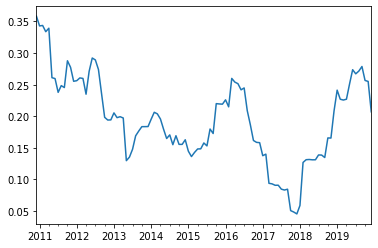

In [55]:
df_result.te.plot()

In [56]:
df_w = pd.DataFrame(weights, index=df_result.index, columns=dvds.columns).shift(1); df_w;

In [57]:
df_w.iloc[-1][df_w.iloc[-1]>0.000001].round(4)

HDV     0.0832
FVD     0.1000
DIV     0.1000
VIG     0.1000
NOBL    0.0168
PGF     0.1000
VYMI    0.1000
DEM     0.1000
DGS     0.1000
DVYE    0.1000
IDV     0.1000
Name: 2019-12-31 00:00:00, dtype: float64

In [58]:
df_rtns = rtns.loc[df_result.index, dvds.columns]; df_rtns;

In [59]:
cum_port0 = (df_w*df_rtns).sum(axis=1).cumsum(); cum_port0;

In [60]:
cum_bm = rtns_bm.loc[df_result.index]['M1ACWIHD INDEX']
cum_bm.iloc[0] = 0
cum_bm = cum_bm.cumsum(); cum_bm;

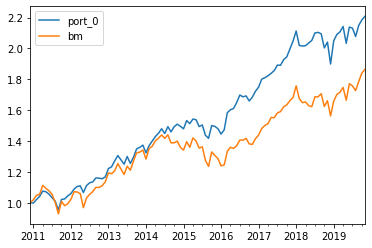

In [61]:
cum = np.exp(pd.DataFrame({'port_0':cum_port0, 'bm':cum_bm})).iloc[:-1]
cum.plot()

In [62]:
std = cum.pct_change().std()*(12**0.5) * 100
cagr = (cum.iloc[-1]**(12/(len(cum)-1))-1) * 100
rar = cagr/std
stats = pd.DataFrame({'cagr':cagr, 'std':std, 'rar':rar})
stats['cagr_ex'] = stats.cagr - stats.cagr['bm']
stats['te'] = cum.pct_change().sub(cum.bm.pct_change(), axis=0).std()*(12**0.5) * 100
stats['ir'] = (stats.cagr_ex/stats.te).fillna(0)
stats.round(2)

,cagr,std,rar,cagr_ex,te,ir
port_0,9.30,9.22,1.01,2.06,4.46,0.46
bm,7.24,11.29,0.64,0.00,0.00,0.00


# 모멘텀 종목 고르는 경우

In [65]:
'''
변수설정
'''
n_dates = len(rtns)
n_cov = 12             # cov 계산 개월수

bm_w_max = 0.00
w_max = 0.10           # 종목 최대비중
w_us_min = 0.4         # 미국 최소비중
w_us_max = 0.8         # 미국 최대비중
w_ps_max = 0.1         # 우선주 최대비중
dvd_min = 2.5          # 포트폴리오 최소 배당수익률
te_limit_max = 0.05
te_limit_min = 0.01

n = len(rtns.columns)  # 종목수
dates_rng = range(n_cov, n_dates)
weights = np.zeros((len(dates_rng), n))
result = {}


def covar(rt):
    _cov = rt.cov(min_periods=n_cov/2)
    _exc = _cov.iloc[0].isna()
    return _cov.fillna(0), _exc


def has_value(rt, n_filter, investable):
    set_trace()
    vals = (-rt.iloc[-1] / rt.iloc[-12:].sum(min_count=6)).values
    vals[investable.values==0][:] = np.nan
    vals[-2:] = np.nan
    univ['value'] = vals
    out = univ.groupby('category')['value'].rank(ascending=False, pct=True, na_option='bottom') <= n_filter
    out[0] = 1
    return out


for i in tqdm_notebook(dates_rng[:]):
    date = rtns.index[i]
    
    _rtns = rtns.iloc[i-11:i+1]
    cov, exc = covar(_rtns)
    dvd = dvds.iloc[i]
    
    investable = 1 - (dvd.isna() | _rtns.iloc[-1].isna() | exc)
    investable = investable.values * has_value(_rtns, 0.5, investable)
    #investable = has_value(_rtns, 0.5, investable)
    investable.iloc[0] = 1
    investable.iloc[-2:] = 0
    
    w_p0 = (1/_rtns.std()) * investable.values
    w_p0 = w_p0.fillna(0) / w_p0.sum()

    #valuable = has_value(_rtns, 0.5, investable)
    
    _w_max = w_max*investable
    #_w_max = w_p0.copy()# * 3
    #_w_max[valuable.values] = _w_max * 6
    #_w_max[~valuable.values] = _w_max * 0
    #_w_max[_w_max>w_max] = w_max
    _w_max.iloc[0] = bm_w_max
    bounds = list(zip(np.zeros(n), _w_max))
    

    def objective(w_p):
        return te(w_p)
        #return -sharpe(w_p)
        #return -ir(w_p)
    
    
    def sharpe(w_p):
        _rp = rtn_projection(w_p)
        _vol = vol(w_p)
        return _rp / _vol

    def ir(w_p):
        _rp = rtn_projection(w_p, rel=True)
        _te = te(w_p)
        return _rp / _te
    
    
    def rtn_projection(w_p, rel=False):
        _rtns_sum = _rtns.iloc[:-1].sum().fillna(0)
        _proj = _rtns_sum @ w_p
        
        if rel:
            return _proj - _rtns_sum[0]
        else:
            return _proj
        
    
    def vol(w_p, te=False):
        ww = w_p.copy()
        if te: ww[0] += 1
        var = 12 * (ww @ cov @ ww)
        return var**0.5
        
        
    def te(w_p):
        return vol(w_p, te=True)

    def te_max(w_p):
        return te_limit_max - te(w_p)
    
    def te_min(w_p):
        return te(w_p) - te_limit_min
    
    def rp_err_max(w_p):
        #set_trace()
        #rp = (w_p>0.00001) * (1 / _rtns.std())
        #rp /= rp.sum()
        #return 0.05 - (rp - w_p).std()
        #return 0.04 - (w_p0 - w_p).std()
        return 0.03 - (w_p0[1:]/w_p0[1:].sum() - w_p[1:]/w_p[1:].sum()).std()
        #return 0.03 - (w_p0 - w_p).abs().max()
        
    
    def sum_to_one(w_p):
        return 1 - w_p.sum()
    
    # 미국 최소비중
    def us_min(w_p):
        return w_p[0]/2 + w_p[1:25].sum() - w_us_min

    # 미국 최대비중
    def us_max(w_p):
        return w_us_max - w_p[0]/2 - w_p[1:25].sum()
    
    # 우선주 최대비중
    def ps_max(w_p):
        return w_ps_max - w_p[20:25].sum()

    
    def port_dvd(w_p):
        return dvd.fillna(0) @ w_p
    
    
    # 포트폴리오 최소 배당수익률
    def dvd_sum_min(w_p):
        return port_dvd(w_p) - dvd_min

    resp = fmin_slsqp(objective, w_p0, 
                      eqcons=[sum_to_one], 
                      ieqcons=[
                          us_min, 
                          us_max, 
                          ps_max, 
                          dvd_sum_min, 
                          #te_max, 
                          #te_min, 
                          #rp_err_max
                      ], 
                      bounds=bounds, 
                      iter=1000, full_output=True, iprint=0)
    
    if resp[3]==0:
        pos = resp[0]
        
    else:
        pos = w_p0
        pos[:] = 0
        pos[0] = 1
        print(date, resp[-1])

        
    weights[i-n_cov,:] = pos
    result[date] = {
        'sharpe': -resp[1], 
        'w_total': pos.sum(),
        'dvd': port_dvd(pos), 
        'te': te(pos), 
    }

> <ipython-input-65-cb310b7ff023>(30)has_value()
     28 def has_value(rt, n_filter, investable):
     29     set_trace()
---> 30     vals = (-rt.iloc[-1] / rt.iloc[-12:].sum(min_count=6)).values
     31     vals[investable.values==0][:] = np.nan
     32     vals[-2:] = np.nan

ipdb> q


BdbQuit: 

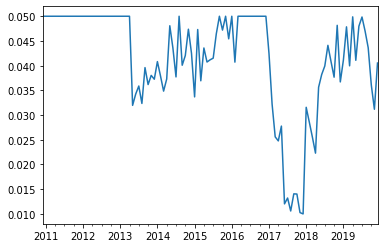

In [1470]:
df_result = pd.DataFrame(result).T; df_result.te.plot()

In [1471]:
df_w = pd.DataFrame(weights, index=df_result.index, columns=dvds.columns).shift(1)

In [1472]:
df_w.round(4).iloc[-1][df_w.iloc[-1]>0.00001]

ACWI    0.2304
FVD     0.1657
VIG     0.1478
NOBL    0.0125
DGRO    0.0119
PGX     0.1000
PID     0.0127
DEM     0.0126
DGS     0.1503
IDV     0.1559
Name: 2019-12-31 00:00:00, dtype: float64

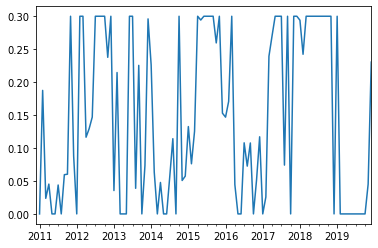

In [1473]:
df_w.ACWI.plot()

In [1474]:
df_rtns = rtns.loc[df_result.index, dvds.columns]

In [1475]:
cum_port1 = (df_w*df_rtns).sum(axis=1).cumsum()

In [1476]:
cum_bm = rtns_bm.loc[df_result.index]['ACWI TR']
cum_bm.iloc[0] = 0
cum_bm = cum_bm.cumsum(); cum_bm;

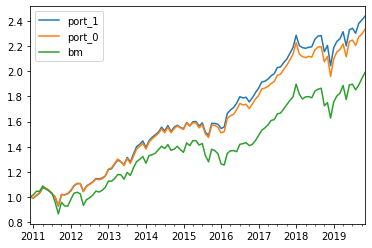

In [1477]:
cum = np.exp(pd.DataFrame({'port_1':cum_port1, 'port_0':cum_port0, 'bm':cum_bm})).iloc[:-1]
cum.plot()

In [1478]:
std = cum.pct_change().std()*(12**0.5) * 100
cagr = (cum.iloc[-1]**(12/(len(cum)-1))-1) * 100
rar = cagr/std
stats = pd.DataFrame({'cagr':cagr, 'std':std, 'rar':rar})
stats['cagr_ex'] = stats.cagr - stats.cagr['bm']
stats['te'] = cum.pct_change().sub(cum.bm.pct_change(), axis=0).std()*(12**0.5) * 100
stats['ir'] = (stats.cagr_ex/stats.te).fillna(0)
stats.round(2)

,cagr,std,rar,cagr_ex,te,ir
port_1,10.51,9.89,1.06,2.49,4.36,0.57
port_0,9.97,9.92,1.01,1.95,4.30,0.45
bm,8.03,12.27,0.65,0.00,0.00,0.00


# BM 모멘텀이 안나올때 UST 편입하는 경우

In [1479]:
df_bm_rtns = rtns['ACWI'].rolling(3).sum().loc[df_result.index]; df_bm_rtns;

In [1480]:
UST = 'TLT'

In [1481]:
df_w_append = df_w.copy()
for date, val in df_bm_rtns.items():
    if val<0:
        df_w_append.loc[date] *= 0.8
        df_w_append.loc[date, UST] = 0.2

In [1482]:
#df_rtns[UST] = rtns.loc[df_result.index, UST]

In [1483]:
cum_port2 = (df_w_append*df_rtns).sum(axis=1).cumsum()

In [1484]:
cum_bm = rtns_bm.loc[df_result.index]['ACWI TR']
cum_bm.iloc[0] = 0
cum_bm = cum_bm.cumsum(); cum_bm;

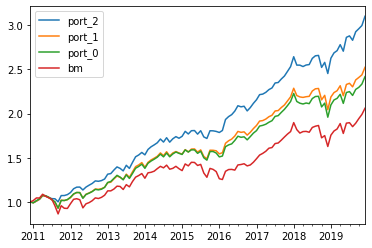

In [1485]:
cum = np.exp(pd.DataFrame({'port_2':cum_port2, 'port_1':cum_port1, 'port_0':cum_port0, 'bm':cum_bm}))#.iloc[:-1]
cum.plot()

In [1486]:
std = cum.pct_change().std()*(12**0.5) * 100
cagr = (cum.iloc[-1]**(12/(len(cum)-1))-1) * 100
rar = cagr/std
stats = pd.DataFrame({'cagr':cagr, 'std':std, 'rar':rar})
stats['cagr_ex'] = stats.cagr - stats.cagr['bm']
stats['te'] = cum.pct_change().sub(cum.bm.pct_change(), axis=0).std()*(12**0.5) * 100
stats['ir'] = (stats.cagr_ex/stats.te).fillna(0)
stats.round(2)

,cagr,std,rar,cagr_ex,te,ir
port_2,13.40,8.30,1.61,5.04,6.03,0.84
port_1,10.84,9.88,1.10,2.47,4.34,0.57
port_0,10.31,9.92,1.04,1.94,4.28,0.45
bm,8.37,12.25,0.68,0.00,0.00,0.00


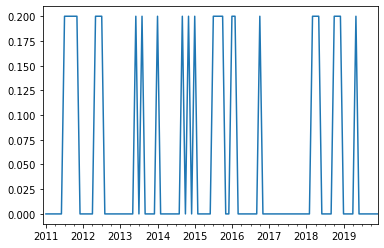

In [1487]:
df_w_append.TLT.plot()

In [1489]:
df_w_append.round(4).iloc[-1][df_w_append.iloc[-1]>0.00001]

ACWI    0.2304
FVD     0.1657
VIG     0.1478
NOBL    0.0125
DGRO    0.0119
PGX     0.1000
PID     0.0127
DEM     0.0126
DGS     0.1503
IDV     0.1559
Name: 2019-12-31 00:00:00, dtype: float64

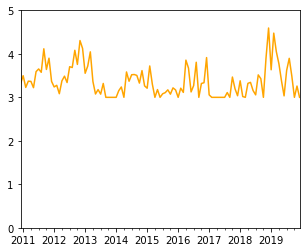

In [1615]:
df_result.dvd.plot(color='orange', figsize=(5,4), ylim=(0,5))

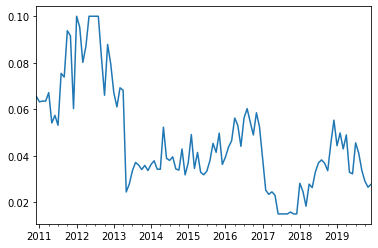

In [1616]:
df_result.te.plot()

In [1618]:
perf = np.exp(pd.DataFrame({'HGDM':cum_port2, 'ACWI':cum_bm}))

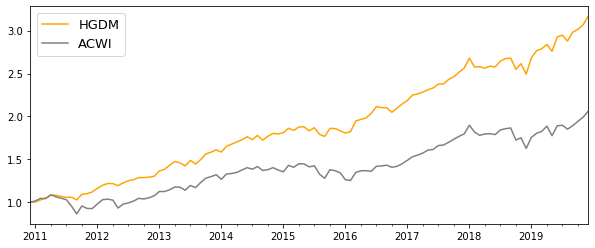

In [1619]:
ax = perf.plot(figsize=(10,4), color=['orange','gray'])
ax.legend(fontsize=13)

In [1620]:
ytd = perf.iloc[-1]/perf.loc['2018-12-31']-1
r3m = perf.iloc[-1]/perf.iloc[-4]-1
r1y = perf.iloc[-1]/perf.iloc[-13]-1
r3y = perf.iloc[-1]/perf.iloc[-37]-1

In [1621]:
pd.DataFrame({'ytd':ytd, '1y':r1y, '3y':r3y})

,ytd,1y,3y
HGDM,0.270204,0.270204,0.476477
ACWI,0.265974,0.265974,0.421700
